In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spark-fund-investment-analysis/datasets/mapping.csv
/kaggle/input/spark-fund-investment-analysis/datasets/rounds2.csv
/kaggle/input/spark-fund-investment-analysis/datasets/companies.txt


In [6]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
root_folder_path = "/kaggle/input/spark-fund-investment-analysis/datasets/"
companies_path = os.path.join(root_folder_path,"companies.txt")
rounds2_path = os.path.join(root_folder_path,"rounds2.csv")
mapping_path = os.path.join(root_folder_path,"mapping.csv")
investment_path =os.path.join(root_folder_path,"Investments.xlsx")

___
#  Checkpoint 1: Data cleaning 1
___

### 1.1 Load Companies and rounds2

In [8]:
companies = pd.read_csv(companies_path, sep='\t', encoding="ISO-8859-1")
companies.head()

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/Organization/-Fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/Organization/-Qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/Organization/-The-One-Of-Them-Inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
3,/Organization/0-6-Com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
4,/Organization/004-Technologies,004 Technologies,http://004gmbh.de/en/004-interact,Software,operating,USA,IL,"Springfield, Illinois",Champaign,01-01-2010


In [9]:
rounds2 = pd.read_csv(rounds2_path, encoding="ISO-8859-1")
rounds2.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,1/3/2014,700000.0
3,/ORGANIZATION/-THE-ONE-OF-THEM-INC-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0


---
**<font size = 4>Question 1. How many unique companies are present in rounds2?</font>**
--

**<ins>Approach</ins>**: Using nunique() function of Pandas DataFrame to get the unique values in each column of the dataframe. Also considering data analysis intricacies, unifying the case of the values of the column to lower case and then cross checking for unique values

In [10]:
rounds2.count()

company_permalink          114949
funding_round_permalink    114949
funding_round_type         114949
funding_round_code          31140
funded_at                  114949
raised_amount_usd           94959
dtype: int64

In [11]:
rounds2.nunique()

company_permalink           90247
funding_round_permalink    114949
funding_round_type             14
funding_round_code              8
funded_at                    5033
raised_amount_usd           22095
dtype: int64

In [12]:
len(rounds2['company_permalink'].str.lower().unique())
#Nan

66370

In [13]:
rounds2_lower = rounds2.copy()
rounds2_lower['company_permalink'] =rounds2_lower['company_permalink'].str.lower()
rounds2[rounds2_lower.duplicated(['company_permalink'],keep=False)].head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
1,/ORGANIZATION/-QOUNTER,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,1/3/2014,700000.0
7,/ORGANIZATION/0NDINE-BIOMEDICAL-INC,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,NaN,11/9/2009,43360.0
8,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,NaN,21-12-2009,719491.0
9,/ORGANIZATION/0XDATA,/funding-round/383a9bd2c04f7038bb543ccef5ba3eae,seed,NaN,22-05-2013,3000000.0


**<sup>Table 1.1 Case Sensitivity in comapny_permalink column of rounds2</sup>**

In [14]:
rounds2_lower.nunique()

company_permalink           66370
funding_round_permalink    114949
funding_round_type             14
funding_round_code              8
funded_at                    5033
raised_amount_usd           22095
dtype: int64

**<ins><font size = 4>Solution</font></ins>**: 
---

Data for **66,370** distinct companies is present in rounds2

<font size = 2>Based on the attributes of rounds2, unique vaues in company_permalink (unique id of company) column gives us the unique companies in rounds 2.But as can be observed, initially nunique()'s output (90247) didn't match with lower case unique values of comapny_permalink. This was due to the presence of same values in different cases (refer to table 1.1). This maybe due to compilation of data from various sources with different format.</font>

---
**<font size = 4>Question 2. How many unique companies are present in companies?</font>**
--

**<ins>Approach</ins>**: Using nunique() function of Pandas DataFrame to get the unique values in each column of the dataframe. Also considering data analysis intricacies, unifying the case of the values of the column to lower case and then cross checking for unique values

In [15]:
companies.nunique()

permalink        66368
name             66102
homepage_url     61191
category_list    27296
status               4
country_code       137
state_code         311
region            1092
city              5111
founded_at        3978
dtype: int64

In [16]:
companies_lower = companies.copy()
companies_lower['permalink'] =companies_lower['permalink'].str.lower()
companies_lower['name'] =companies_lower['name'].str.lower()
companies[companies.duplicated(['name'],keep=False)].head(7)

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
281,/Organization/3Divaz-2,3DIVAZ,http://www.3divaz.ch/Home,NaN,closed,NaN,NaN,NaN,NaN,01-07-2014
282,/Organization/3Divaz-3,3DIVAZ,http://www.3divaz.ch/Home,NaN,operating,CHE,1,CHE - Other,Wildegg,01-07-2014
1526,/Organization/Adtena,Adtena,http://adtena.com/,Ad Targeting|Advertising|Mobile Advertising,operating,NaN,NaN,NaN,NaN,NaN
1527,/Organization/Adtena-2,Adtena,http://adtena.com,NaN,closed,NaN,NaN,NaN,NaN,15-11-2014
1995,/Organization/Agora-3,Agora,http://www.agora.io/,Mobile|Mobile Software Tools|VoIP,operating,USA,CA,SF Bay Area,Palo Alto,01-01-2014
1996,/Organization/Agora-6,Agora,https://www.agora.co,Android|Apps|Internet|Mobile,operating,USA,NY,New York City,New York,01-07-2013
3005,/Organization/Amicus,Amicus,http://amicushq.com,Colleges|Innovation Management|Nonprofits|Poli...,operating,USA,NY,New York City,New York,01-01-2011


**<sup>Table 1.2 Records with same company names but different permalink in companies</sup>**

In [17]:
companies_lower.nunique()

permalink        66368
name             66037
homepage_url     61191
category_list    27296
status               4
country_code       137
state_code         311
region            1092
city              5111
founded_at        3978
dtype: int64

**<ins><font size = 4>Solution</font></ins>**: 
---

Data for **66,367** distinct companies is present in companies based on the permalink(unique id)

<font size = 2>Based on the attributes of rounds2, unique vaues in permalink (unique id of company) column gives us the unique companies in companies. Another interesting observation is the difference between the distinct permalink(66368) and distinct name of company (66037). Observing in detail we can see  records with same company names but different permalink in companies (refer Table 1.2). This can be due to the update in any of the company attribute which leads to creation of new permalink.For instance:
1. Change in *status* from closed to operating( eg. company name = 3DIVAZ)
2. Change in *homepage_url, category_list, state_code, region, city, founded_at* (eg. Agora)</font>

---
**<font size = 4>Question 3. In the companies data frame, which column can be used as the unique key for each company? Write the name of the column.</font>**
--

**<ins>Approach</ins>**: Checking for the properties of primary key: 

                Check 1. Not Null

                Check 2. Unique for all records


Based on this, column/group of column which uniquesly identifies all rows and is present for all rows should be chosen as a primary key(unique key for each company) 

In [18]:
# Check 1: 
# Count of non-empty values present in each column
companies_lower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   permalink      66368 non-null  object
 1   name           66367 non-null  object
 2   homepage_url   61310 non-null  object
 3   category_list  63220 non-null  object
 4   status         66368 non-null  object
 5   country_code   59410 non-null  object
 6   state_code     57821 non-null  object
 7   region         58338 non-null  object
 8   city           58340 non-null  object
 9   founded_at     51147 non-null  object
dtypes: object(10)
memory usage: 5.1+ MB


**<ins>Note</ins>**: Only permalink and status column have values for all 66368 rows

In [19]:
# Check 2:
# Count of non-empty values present in each column
companies_lower.nunique()

permalink        66368
name             66037
homepage_url     61191
category_list    27296
status               4
country_code       137
state_code         311
region            1092
city              5111
founded_at        3978
dtype: int64

**<ins>Note</ins>**: Only permalink column have 6638 uniquevalues for all 66368 rows

**<ins><font size = 4>Solution</font></ins>**:
---
The column named **permalink** passes both the checks and can be used as a primary key to uniquely identify each company.

(Assumption: each record in companies is representing a company)

---
**<font size = 4>Question 4. Are there any companies in the rounds2 file which are not present in companies? Answer yes or no: Y/N</font>**
---

**<ins><font size = 4>Solution</font></ins>**:
---
Y

Yes, as can be seen from the answers of question 1 and 2, data for  66370 unique companies is present in rounds 2 but in companies data for only 66368 unique companies is present. Hence there must be <ins>atleast 2</ins> companies which are present in rounds2 but not in companies. On further analyis we can see there are exactly 7 company permalink whose data is present in rounds2 but not in companies

In [20]:
rounds2[~rounds2_lower['company_permalink'].isin(companies_lower ['permalink'])]

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
29597,/ORGANIZATION/E-CÃBICA,/funding-round/8491f74869e4fe8ba9c378394f8fbdea,seed,NaN,1/2/2015,NaN
31863,/ORGANIZATION/ENERGYSTONE-GAMES-ÇµÇ³Æ¸¸Æ,/funding-round/b89553f3d2279c5683ae93f45a21cfe0,seed,NaN,9/8/2014,NaN
45176,/organization/huizuche-com-æ ç§ÿè½¦,/funding-round/8f8a32dbeeb0f831a78702f83af78a36,seed,NaN,18-09-2014,NaN
58473,/ORGANIZATION/MAGNET-TECH-Ç£Ç³Ç§Æ,/funding-round/8fc91fbb32bc95e97f151dd0cb4166bf,seed,NaN,16-08-2014,1625585.0
101036,/organization/tipcat-interactive-æ²èÿä¿¡æ¯ç...,/funding-round/41005928a1439cb2d706a43cb661f60f,seed,NaN,6/9/2010,NaN
109969,/ORGANIZATION/WEICHE-TECH-ÅÈ½¦Ç§Æ,/funding-round/f74e457f838b81fa0b29649740f186d8,venture,A,6/9/2015,NaN
113839,/ORGANIZATION/ZENGAME-Ç¦ Æ¸¸Ç§Æ,/funding-round/6ba28fb4f3eadf5a9c6c81bc5dde6cdf,seed,NaN,17-07-2010,NaN


**<sup>Table 1.3 Showing the permalinks present in rounds but not in companies</sup>**

In [21]:
#But we can see companies with similar prefix (from table 1.3) in companies
companies[companies.permalink.str.upper().str.contains("/ORGANIZATION/MAGNET-TECH-")]

,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
33892,/Organization/Magnet-Tech-Ç£Çÿ³Ç§Æ,Magnet Tech ç£ç³ç§æ,http://www.buga.cn,Communications Hardware|Families|Hardware + So...,closed,NaN,NaN,NaN,NaN,02-05-2014


---
<font size = 4>Question 5. Merge the two data frames so that all variables (columns) in the companies frame are added to the rounds2 data frame. Name the merged frame master_frame. How many observations are present in master_frame?</font>
---

**<ins>Approach</ins>**: For each dataframe, use the dataframe with lower case values of primary key column (company_permalink for rounds2 and permalink for companies) and join them to master_frame. As investment data irrespective of the company is important but companies with no investment are not crucial for this analysis, using logic rounds2 <ins>left join</ins> companies

In [22]:
master_frame = rounds2_lower.merge(companies_lower,how='left',left_on=['company_permalink'],right_on=['permalink'] )
master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
1,/organization/-qounter,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,14-10-2014,NaN,/organization/-qounter,:qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,1/3/2014,700000.0,/organization/-qounter,:qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(the) one of them,inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007


In [23]:
master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114949 entries, 0 to 114948
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   company_permalink        114949 non-null  object 
 1   funding_round_permalink  114949 non-null  object 
 2   funding_round_type       114949 non-null  object 
 3   funding_round_code       31140 non-null   object 
 4   funded_at                114949 non-null  object 
 5   raised_amount_usd        94959 non-null   float64
 6   permalink                114942 non-null  object 
 7   name                     114941 non-null  object 
 8   homepage_url             108810 non-null  object 
 9   category_list            111535 non-null  object 
 10  status                   114942 non-null  object 
 11  country_code             106271 non-null  object 
 12  state_code               104003 non-null  object 
 13  region                   104782 non-null  object 
 14  city

**<font size = 4><ins>Solution</ins></font>**:
---
There are **1,14,949** observations present in the master_frame

**<font size = 4>Checkpoint 1: Expected Results</font>**

|S.No|Questions| Answer     |
|:---:|:------------|:-------------:| 
|1.|How many unique companies are present in rounds2?       | **66,370** |
|2.|How many unique companies are<br/> present in the companies file?  | **66,367**|
|3.|In the companies data frame, which column can be used <br/>as the unique key for each company? <br/>Write the name of the column.|**permalink** |
|4.|Are there any companies in the rounds2 file<br/> which are not  present in companies ? |**Yes**|
|5.|Merge the two data frames so that all  variables (columns)<br/> in the companies frame are added to the rounds2 data frame<br/>Name the merged frame master_frame. <br/> How many observations are present in master_frame ?|**1,14,949**|

___
#  Checkpoint 2: Funding Type Analysis
---

In [24]:
print(master_frame['funding_round_type'].unique())

['venture' 'seed' 'undisclosed' 'equity_crowdfunding' 'convertible_note'
 'private_equity' 'debt_financing' 'angel' 'grant' 'secondary_market'
 'post_ipo_equity' 'post_ipo_debt' 'product_crowdfunding'
 'non_equity_assistance']


*Reference*:The funding types such as seed, venture, angel, etc. depend on the type of the company (startup, corporate, etc.), its stage (early stage startup, funded startup, etc.), the amount of funding *(a few million USD to a billion USD)*, and so on. For example, seed, angel and venture are three common stages of startup funding.

*Seed/angel* funding refer to *early stage* startups whereas *venture* funding occurs after seed or angel stage/s and involves a *relatively higher amount of investment*.
*Private equity type investments* are associated with much larger companies and involve *much higher investments than venture type*. Startups which have grown in scale may also receive private equity funding. This means that if a company has reached the venture stage, it would have already passed through the angel or seed stage/s.

**<ins>Note</ins>**: funding hierarchy is as follow - seed | angel < venture < private equity

___
### <font siz=4>2.1 Calculate the most representative value of the investment amount for each of the four funding types (venture, angel, seed, and private equity) and report the answers 

In [25]:
# subsetting and checking the distribution and nulls for the four funding types
selected_funding_types = ['venture','angel','seed','private_equity']
selected_funds_master_frame = master_frame[(master_frame['funding_round_type']==selected_funding_types[0])|(master_frame['funding_round_type']==selected_funding_types[1])|(master_frame['funding_round_type']==selected_funding_types[2])|(master_frame['funding_round_type']==selected_funding_types[3])]

In [26]:
selected_funds_master_frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94397 entries, 0 to 114947
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        94397 non-null  object 
 1   funding_round_permalink  94397 non-null  object 
 2   funding_round_type       94397 non-null  object 
 3   funding_round_code       31120 non-null  object 
 4   funded_at                94397 non-null  object 
 5   raised_amount_usd        80627 non-null  float64
 6   permalink                94390 non-null  object 
 7   name                     94389 non-null  object 
 8   homepage_url             90247 non-null  object 
 9   category_list            91896 non-null  object 
 10  status                   94390 non-null  object 
 11  country_code             87076 non-null  object 
 12  state_code               85118 non-null  object 
 13  region                   85838 non-null  object 
 14  city                 

In [27]:
#as we can see some nulls in the above results, calculating the number of nulls for each funding type
print("count of non-empty values of investments by funding type:")
print(selected_funds_master_frame.groupby(by='funding_round_type').agg({'funding_round_type':['count']}))
print("count of nulls values of investments by funding type:")
selected_funds_master_frame[selected_funds_master_frame['raised_amount_usd'].isnull()].groupby(by='funding_round_type').agg({'funding_round_type':['count']})

count of non-empty values of investments by funding type:
                   funding_round_type
                                count
funding_round_type                   
angel                            6094
private_equity                   2285
seed                            30524
venture                         55494
count of nulls values of investments by funding type:


,funding_round_type
,count
funding_round_type,
angel,1234
private_equity,349
seed,6921
venture,5266


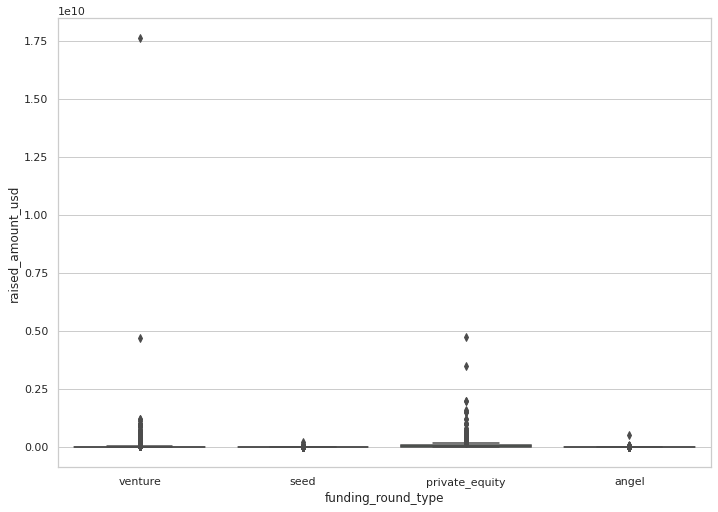

In [28]:
#As we know that the amount of funding for each of these types varies significantly in general, without imputing the nulls we will miss
# a significant amount of that funding type which is important for analysis
#To understand the distribution better, plotting bar graph
sns.set(style="whitegrid")
boxplot_1 = sns.boxplot(x=selected_funds_master_frame.funding_round_type, y=selected_funds_master_frame.raised_amount_usd)
boxplot_1

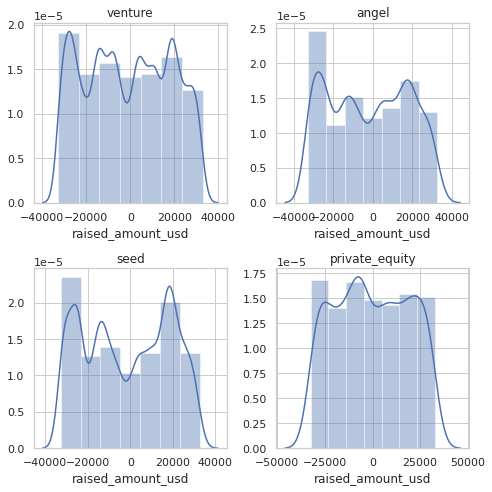

In [29]:
#checking distribution of each funding type of importance
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(7, 7))
warnings.filterwarnings("ignore")
for i, ax in zip(range(0,len(selected_funding_types)), axes.flat):
    #print(selected_funding_types[i])
    funding = selected_funds_master_frame[selected_funds_master_frame['funding_round_type']==selected_funding_types[i]]
    funding = funding[~funding['raised_amount_usd'].isnull()]
    x = funding['raised_amount_usd'].astype(np.int16)
    sns.distplot(x,bins=7,ax=ax)
    ax.title.set_text(selected_funding_types[i])
    
plt.tight_layout()
plt.show()


*Plot: ditribution of investment by funding type*

In [30]:
# Taking into account the outliers present in data, median is more suitable value to fill the nulls
# Hence using median of the funding type by country to impute the values, it is the most representative value of distribution
median_lookup = selected_funds_master_frame
median_lookup= median_lookup.groupby(['funding_round_type', 'country_code']).median()
median_lookup.reset_index(inplace=True)
null_investment_records_df = selected_funds_master_frame[selected_funds_master_frame.raised_amount_usd.isnull()]
#without null in investment
investment_records_df = selected_funds_master_frame[selected_funds_master_frame.raised_amount_usd.notnull()]
# Now we will try to impute the values in master_amt_null
imputed_null_df = null_investment_records_df.merge(median_lookup, on= ['funding_round_type','country_code'] ,how = 'left')
#Normalizing and concatenating the imputed nulls and not null records together
imputed_null_df = imputed_null_df.drop(columns= ['raised_amount_usd_x'])
imputed_null_df = imputed_null_df.rename(columns= {"raised_amount_usd_y" : "raised_amount_usd"} )
imputed_master_df = pd.concat([investment_records_df,imputed_null_df])
imputed_master_df.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
2,/organization/-qounter,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,1/3/2014,700000.0,/organization/-qounter,:qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,operating,USA,DE,DE - Other,Delaware City,04-09-2014
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(the) one of them,inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
7,/organization/0ndine-biomedical-inc,/funding-round/2b9d3ac293d5cdccbecff5c8cb0f327d,seed,NaN,11/9/2009,43360.0,/organization/0ndine-biomedical-inc,ondine biomedical inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver,01-01-1997


In [31]:
imputed_master_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94397 entries, 0 to 13769
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   company_permalink        94397 non-null  object 
 1   funding_round_permalink  94397 non-null  object 
 2   funding_round_type       94397 non-null  object 
 3   funding_round_code       31120 non-null  object 
 4   funded_at                94397 non-null  object 
 5   raised_amount_usd        92078 non-null  float64
 6   permalink                94390 non-null  object 
 7   name                     94389 non-null  object 
 8   homepage_url             90247 non-null  object 
 9   category_list            91896 non-null  object 
 10  status                   94390 non-null  object 
 11  country_code             87076 non-null  object 
 12  state_code               85118 non-null  object 
 13  region                   85838 non-null  object 
 14  city                  

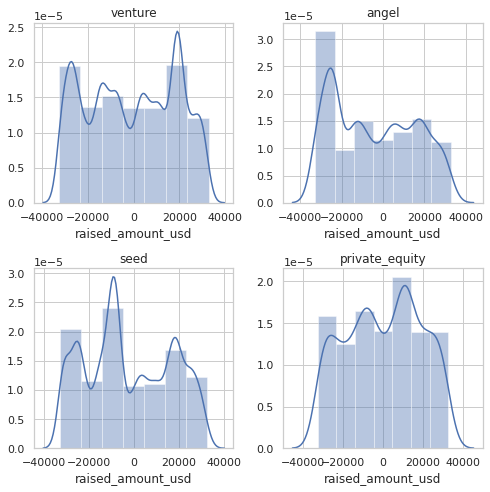

In [32]:
#Verification: As can be most of the nulls in the investment amount are filled (exceptions are countries with no relevant data for the particular funding type)
# Main check: after imputing with the nulls, the distribution of data has not changed
df =imputed_master_df
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(7, 7))
warnings.filterwarnings("ignore")
for i, ax in zip(range(0,len(selected_funding_types)), axes.flat):
    #print(selected_funding_types[i])
    funding = df[df['funding_round_type']==selected_funding_types[i]]
    funding = funding[~funding['raised_amount_usd'].isnull()]
    x = funding['raised_amount_usd'].astype(np.int16)
    sns.distplot(x,bins=7,ax=ax)
    ax.title.set_text(selected_funding_types[i])
    
plt.tight_layout()
plt.show()
imputed_selected_funds_master_frame =df

*Plot: ditribution of investment by funding type*

In [33]:
investment_by_funding_type_grouped = imputed_selected_funds_master_frame.groupby(['funding_round_type','country_code'])
investment_by_funding_type = investment_by_funding_type_grouped.agg({'raised_amount_usd': [np.mean,np.median,np.max,np.min]})
investment_by_funding_type.sort_values(by=[('raised_amount_usd','mean')],ascending = False)
investment_by_funding_type.head()

raised_amount_usd                       \
                                             mean    median       amax   
funding_round_type country_code                                          
angel              ARE               5.262500e+05  400000.0  1991250.0   
                   ARG               2.583207e+05  123220.0  1000000.0   
                   AUS               1.063682e+06  626562.0  5810000.0   
                   AUT               5.920816e+05  500000.0  2500000.0   
                   BEL               6.408253e+05  694895.0  1932650.0   

                                          
                                    amin  
funding_round_type country_code           
angel              ARE           45000.0  
                   ARG           20000.0  
                   AUS            8733.0  
                   AUT           80000.0  
                   BEL           66230.0

In [34]:
investment_by_funding_type_grouped =imputed_selected_funds_master_frame.groupby(['funding_round_type'])
investment_by_funding_type = investment_by_funding_type_grouped.agg({'raised_amount_usd': ['mean','median','max','min','count']})
investment_by_funding_type.sort_values(by=[('raised_amount_usd','mean')],ascending = False)
investment_by_funding_type

raised_amount_usd                                      
                                mean      median           max  min  count
funding_round_type                                                        
angel                   8.686541e+05    450000.0  4.945120e+08  0.0   5905
private_equity          6.750296e+07  19999999.5  4.745460e+09  0.0   2207
seed                    6.553549e+05    357000.0  2.000000e+08  0.0  29237
venture                 1.122720e+07   5000000.0  1.760000e+10  0.0  54729

In [35]:
investment_by_funding_type.loc['venture',:]

raised_amount_usd  mean      1.122720e+07
                   median    5.000000e+06
                   max       1.760000e+10
                   min       0.000000e+00
                   count     5.472900e+04
Name: venture, dtype: float64

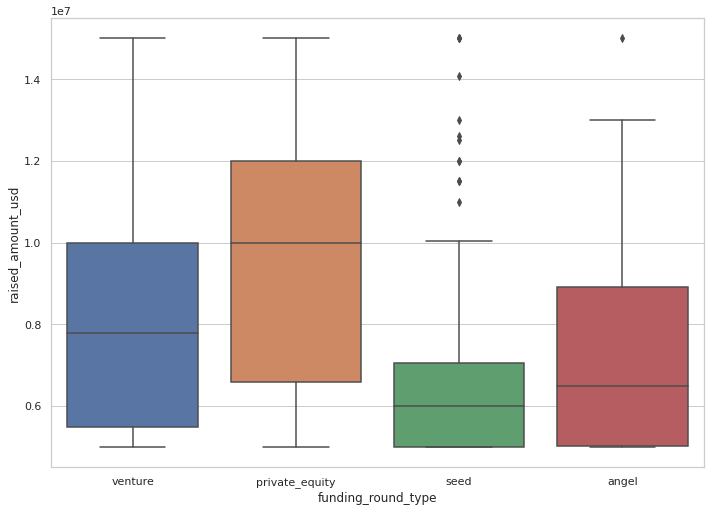

In [36]:
# checking the distribution of investments per round having values between 5 to 15 million
investment_limit_lower = 5000000
investment_limit_upper = 15000000
funds_master_frame=imputed_selected_funds_master_frame[(imputed_selected_funds_master_frame['raised_amount_usd']>=investment_limit_lower)&(imputed_selected_funds_master_frame['raised_amount_usd']<=investment_limit_upper)]
sns.set(style="whitegrid")
boxplot_2 = sns.boxplot(x=funds_master_frame.funding_round_type, y=funds_master_frame.raised_amount_usd)
boxplot_2

___
### 2.2 Based on the most representative investment amount calculated above, which investment type do you think is the most suitable for Spark Funds?

Considering that Spark Funds wants to invest between 5 to 15 million USD per investment round, which investment type is the most suitable for it? Identify the investment type and, for further analysis, filter the data so it only contains the chosen investment type.

**<font size = 4><ins>Solution</ins></font>**:
---
Going by the mean values of investment in USD, only the overall mean (11,843,872.72 USD) of **venture** funding type lies within 5 to 15 million USD per investment round and it has dense distribution in the range of 5-15 million USD

In [37]:
for fund_type in selected_funding_types:
    print(fund_type,end=': ')
    print( investment_by_funding_type.loc[fund_type,('raised_amount_usd','mean')])

venture: 11227199.209916132
angel: 868654.101100762
seed: 655354.8834011698
private_equity: 67502962.62641595


**<font size = 4>Checkpoint 2: Expected Results</font>**

|S.no.|Questions | Initial values (in USD)|After imputing nulls (in USD)
|:---:|:--------:|:------:|:------:|
|1.|Average funding amount of venture type|**11,748,949.13**|**11,227,199.21**|
|2.|Average funding amount of angel type  |**958,694.47**|**868,654.10**|
|3.|Average funding amount of seed type   |**719,818.00**|**655,354.88**|
|4.|Average funding amount of private equity type|**73,308,593.03**|**67,502,962.62**|
|5.|Considering that Spark Funds wants to invest<br/>between 5 to 15 million USD per  investment<br/>round, which investment type is the most <br/>suitable for them?|**venture**|**venture**|


___
#  Checkpoint 3: Country Analysis
---

Spark Funds wants to invest in countries with the highest amount of funding for the chosen investment type. This is a part of its broader strategy to invest where most investments are occurring.

---
### <font size=4>3.1 Spark Funds wants to see the top nine countries which have received the highest total funding (across ALL sectors for the chosen investment type)


In [38]:
chosen_investment_type = 'venture'
# taking only the venture investment from master frame
selected_master_frame = imputed_selected_funds_master_frame[imputed_selected_funds_master_frame['funding_round_type']==chosen_investment_type]
print(selected_master_frame['funding_round_type'].unique())
print(selected_master_frame['country_code'].unique())

['venture']
['IND' nan 'CHN' 'CAN' 'USA' 'GBR' 'FRA' 'ROM' 'KOR' 'IRL' 'SWE' 'SGP'
 'NLD' 'RUS' 'BEL' 'ESP' 'HUN' 'JPN' 'DEU' 'ITA' 'HKG' 'BRA' 'FIN' 'CHE'
 'PRT' 'SVN' 'THA' 'DNK' 'TWN' 'ISR' 'NOR' 'LTU' 'ISL' 'MEX' 'AUS' 'NZL'
 'AUT' 'ARG' 'PHL' 'MNE' 'MYS' 'TUR' 'POL' 'LVA' 'GGY' 'EST' 'LBN' 'GRC'
 'IDN' 'CYP' 'SVK' 'ARE' 'EGY' 'ARM' 'ZAF' 'TUN' 'KEN' 'COL' 'CZE' 'CMR'
 'PRI' 'CYM' 'PER' 'ECU' 'CHL' 'NGA' 'VNM' 'URY' 'PAK' 'HRV' 'LUX' 'UKR'
 'BMU' 'MUS' 'BGR' 'TTO' 'PAN' 'MMR' 'JOR' 'KAZ' 'MAR' 'LIE' 'GTM' 'SAU'
 'TAN' 'KNA' 'SEN' 'MLT' 'MCO' 'BAH' 'GHA' 'KWT' 'UGA' 'LAO' 'BGD' 'BWA'
 'MAF' 'GIB' 'PSE' 'CRI' 'RWA' 'MOZ' 'MKD' 'BHR']


In [39]:
#
investment_by_country = selected_master_frame.groupby(['country_code'])
investment_by_country = investment_by_country.agg({'raised_amount_usd': ['sum','max','min','count']})
investment_by_country = investment_by_country.sort_values(by=[('raised_amount_usd','sum')],ascending = False)
investment_by_country.head()

raised_amount_usd                              
                           sum           max      min  count
country_code                                                
USA               4.336758e+11  1.760000e+10      0.0  38372
CHN               4.506542e+10  1.100000e+09  20000.0   2087
GBR               2.131203e+10  9.150000e+08      0.0   2303
IND               1.565186e+10  1.000000e+09      0.0    992
CAN               9.943332e+09  1.650000e+08   4697.0   1346

---
### <font size =4>3.2 For the chosen investment type, make a data frame named top9 with the top nine countries (based on the total investment amount each country has received)

In [40]:
# choosing top 9 by total sum of investment amount
top9= investment_by_country.nlargest(9,[('raised_amount_usd','sum')])

In [41]:
top9

raised_amount_usd                              
                           sum           max      min  count
country_code                                                
USA               4.336758e+11  1.760000e+10      0.0  38372
CHN               4.506542e+10  1.100000e+09  20000.0   2087
GBR               2.131203e+10  9.150000e+08      0.0   2303
IND               1.565186e+10  1.000000e+09      0.0    992
CAN               9.943332e+09  1.650000e+08   4697.0   1346
DEU               7.599332e+09  1.701774e+08      0.0    786
FRA               7.524737e+09  5.000000e+08  30488.0    985
ISR               7.477515e+09  1.500000e+08      6.0    910
JPN               3.541877e+09  2.360000e+08  14542.0    318

___
### <font size =4> 3.3 Identify the top three English-speaking countries in the data frame top9. 

Iterating over the top 9 df in decreasing order of investment and checking if english spoken there:<br/>
reference : https://en.wikipedia.org/wiki/List_of_territorial_entities_where_English_is_an_official_language
    
    USA : English is a de facto official language
    
    CHN : No Data (Hence non-english speaking country)
    
    GBR : English is a de facto official language
    
    IND : English is a de jure and de facto official language

**<font size = 4>Checkpoint 3: Expected Results</font>**

|S.no.|Questions | Answers|
|:---:|:--------:|:------:|
 |1. |Top English-speaking country	|**USA**|              
 |2. |Second English-speaking country|**GBR**|	 
 |3. |Third English-speaking country |**IND**| 

___
#  Checkpoint 4: Sector Analysis 1
---

When we say sector analysis, we refer to one of the eight main sectors (named main_sector) listed in the mapping file (note that ‘Other’ is one of the eight main sectors). This is to simplify the analysis by grouping the numerous category lists (named ‘category_list’) in the mapping file. For example, in the mapping file, category_lists such as ‘3D’, ‘3D Printing’, ‘3D Technology’, etc. are mapped to the main sector ‘Manufacturing’.

Also, for some companies, the category list is a list of multiple sub-sectors separated by a pipe (vertical bar |). For example, one of the companies’ category_list is Application Platforms|Real Time|Social Network Media.
 

You discuss with the CEO and come up with the business rule that the first string before the vertical bar will be considered the primary sector. In the example above, ‘Application Platforms’ will be considered the primary sector.

In [42]:
sector_mapping_df = pd.read_csv(mapping_path, encoding="ISO-8859-1")
# checked No category belong to more than 1 main category
print(sector_mapping_df[sector_mapping_df.sum(axis=1)>1])
# main category wise the count of sub categories present
print(sector_mapping_df.sum(axis=0))
sector_mapping_df.head()

Empty DataFrame
Columns: [category_list, Automotive & Sports, Blanks, Cleantech / Semiconductors, Entertainment, Health, Manufacturing, News, Search and Messaging, Others, Social, Finance, Analytics, Advertising]
Index: []
Automotive & Sports                         22
Blanks                                       1
Cleantech / Semiconductors                  53
Entertainment                               89
Health                                      63
Manufacturing                               40
News, Search and Messaging                  72
Others                                     195
Social, Finance, Analytics, Advertising    153
dtype: int64


,category_list,Automotive & Sports,Blanks,Cleantech / Semiconductors,Entertainment,Health,Manufacturing,"News, Search and Messaging",Others,"Social, Finance, Analytics, Advertising"
0,NaN,0,1,0,0,0,0,0,0,0
1,3D,0,0,0,0,0,1,0,0,0
2,3D Printing,0,0,0,0,0,1,0,0,0
3,3D Technology,0,0,0,0,0,1,0,0,0
4,Accounting,0,0,0,0,0,0,0,0,1


---
### <font size=4>4.1 Extract the primary sector of each category list from the category_list column

In [43]:
selected_master_frame.dtypes

company_permalink           object
funding_round_permalink     object
funding_round_type          object
funding_round_code          object
funded_at                   object
raised_amount_usd          float64
permalink                   object
name                        object
homepage_url                object
category_list               object
status                      object
country_code                object
state_code                  object
region                      object
city                        object
founded_at                  object
dtype: object

In [44]:
# correcting the dtypes
selected_master_frame.astype({
    'company_permalink': 'str',
    'funding_round_permalink': 'str',
    'funding_round_type': 'str',
    'funding_round_code': 'str',
   'funded_at':'datetime64[ns]',
    'category_list':'str',
    'status':'str',
    'country_code':'str',
'state_code':'str',
'region':'str',
'city':'str',
'founded_at':'str'   
}).dtypes

company_permalink                  object
funding_round_permalink            object
funding_round_type                 object
funding_round_code                 object
funded_at                  datetime64[ns]
raised_amount_usd                 float64
permalink                          object
name                               object
homepage_url                       object
category_list                      object
status                             object
country_code                       object
state_code                         object
region                             object
city                               object
founded_at                         object
dtype: object

In [45]:
selected_master_frame.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list,status,country_code,state_code,region,city,founded_at
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN
3,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(the) one of them,inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN
4,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007
8,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,NaN,21-12-2009,719491.0,/organization/0ndine-biomedical-inc,ondine biomedical inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver,01-01-1997
10,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,9/11/2015,20000000.0,/organization/0xdata,h2o.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011


In [46]:
primary_category_fn = lambda category_list: str(category_list).split('|')[0]
selected_master_frame['primary_sector'] = selected_master_frame['category_list'].apply(primary_category_fn)
selected_master_frame[['category_list','primary_sector']].head()

,category_list,primary_sector
0,Media,Media
3,Apps|Games|Mobile,Apps
4,Curated Web,Curated Web
8,Biotechnology,Biotechnology
10,Analytics,Analytics


In [47]:
# reforming mapping df
sector_mapping_df_melted = sector_mapping_df.melt(id_vars="category_list",var_name="main_sector")
sector_mapping_df_melted = sector_mapping_df_melted[sector_mapping_df_melted["value"]>0]
sector_mapping_df_melted=sector_mapping_df_melted.drop(columns="value")
sector_mapping_df_melted.category_list.unique()

array(['Adventure Travel', 'Aerospace', 'Auto', 'Automated Kiosk',
       'Automotive', 'Bicycles', 'Boating Industry', 'CAD', 'Cars',
       'Design', 'Designers', 'Drones', 'Electric Vehicles', 'Fuels',
       'Heavy Industry', 'Industrial Automation', 'Limousines', 'Soccer',
       'Sporting Goods', 'Sports', 'Transportation',
       'Unmanned Air Systems', nan, 'Air Pollution Control',
       'Aquaculture', 'Bio-Pharm', 'Biofuels', 'Bioinformatics',
       'Biomass Power Generation', 'Biometrics', 'Biotechnology',
       'Bitcoin', 'Carbon', 'Chemicals', 'Clean Energy',
       'Clean Technology', 'Clean Technology IT', 'Commercial Solar',
       'Commodities', 'Concentrated Solar Power', 'Disruptive Models',
       'Early-Stage Technology', 'Energy', 'Energy Efficiency',
       'Energy IT', 'Energy Ma0gement', 'Energy Storage',
       'Environmental Innovation', 'Fertility', 'Fuel Cells',
       'Funeral Industry', 'Gas', 'Green', 'Green Consumer Goods',
       'Home & Garden', 'Ho

In [48]:
#As observed in the category list in place of string 'na' in the words, '0' can be seen 
# correction: As values like Enterprise 2.0 also contains 0, using regular expression
correction = lambda x: str(x).replace("0","na") if (re.search("[^0-9\.]0",str(x)) != None)  or (re.search("\d\.0",str(x)) == None) else str(x)
sector_mapping_df_melted['category_list'] = sector_mapping_df_melted['category_list'].apply(correction).str.lower()
sector_mapping_df_melted['category_list'].unique()

array(['adventure travel', 'aerospace', 'auto', 'automated kiosk',
       'automotive', 'bicycles', 'boating industry', 'cad', 'cars',
       'design', 'designers', 'drones', 'electric vehicles', 'fuels',
       'heavy industry', 'industrial automation', 'limousines', 'soccer',
       'sporting goods', 'sports', 'transportation',
       'unmanned air systems', 'nan', 'air pollution control',
       'aquaculture', 'bio-pharm', 'biofuels', 'bioinformatics',
       'biomass power generation', 'biometrics', 'biotechnology',
       'bitcoin', 'carbon', 'chemicals', 'clean energy',
       'clean technology', 'clean technology it', 'commercial solar',
       'commodities', 'concentrated solar power', 'disruptive models',
       'early-stage technology', 'energy', 'energy efficiency',
       'energy it', 'energy management', 'energy storage',
       'environmental innovation', 'fertility', 'fuel cells',
       'funeral industry', 'gas', 'green', 'green consumer goods',
       'home & garden', 

In [49]:
selected_master_frame['primary_sector']= selected_master_frame['primary_sector'].str.lower()
master_frame_with_main_sector = selected_master_frame.merge(sector_mapping_df_melted,how='left',left_on='primary_sector',right_on='category_list',suffixes=('_frm_master','_frm_mapping'))

In [50]:
master_frame_with_main_sector.head()

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_frm_master,status,country_code,state_code,region,city,founded_at,primary_sector,category_list_frm_mapping,main_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,operating,IND,16,Mumbai,Mumbai,NaN,media,media,Entertainment
1,/organization/-the-one-of-them-inc-,/funding-round/650b8f704416801069bb178a1418776b,venture,B,30-01-2014,3406878.0,/organization/-the-one-of-them-inc-,"(the) one of them,inc.",http://oneofthem.jp,Apps|Games|Mobile,operating,NaN,NaN,NaN,NaN,NaN,apps,apps,"News, Search and Messaging"
2,/organization/0-6-com,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,19-03-2008,2000000.0,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,operating,CHN,22,Beijing,Beijing,01-01-2007,curated web,curated web,"News, Search and Messaging"
3,/organization/0ndine-biomedical-inc,/funding-round/954b9499724b946ad8c396a57a5f3b72,venture,NaN,21-12-2009,719491.0,/organization/0ndine-biomedical-inc,ondine biomedical inc.,http://ondinebio.com,Biotechnology,operating,CAN,BC,Vancouver,Vancouver,01-01-1997,biotechnology,biotechnology,Cleantech / Semiconductors
4,/organization/0xdata,/funding-round/3bb2ee4a2d89251a10aaa735b1180e44,venture,B,9/11/2015,20000000.0,/organization/0xdata,h2o.ai,http://h2o.ai/,Analytics,operating,USA,CA,SF Bay Area,Mountain View,01-01-2011,analytics,analytics,"Social, Finance, Analytics, Advertising"


In [51]:
master_frame_with_main_sector[(master_frame_with_main_sector['main_sector'].isnull())]['primary_sector'].unique()

array(['english-speaking', 'enterprise hardware', 'natural gas uses',
       'adaptive equipment', 'racing', 'specialty retail', 'nightlife',
       'biotechnology and semiconductor', 'rapidly expanding',
       'product search', 'greentech', 'retirement'], dtype=object)

**<font size = 4>Checkpoint 4: Expected Results</font>**

In [52]:
#Code for a merged data frame with each primary sector mapped to its main sector (the primary sector should be present in a separate column).
master_frame_with_main_sector
master_frame_with_main_sector.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55494 entries, 0 to 55493
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   company_permalink          55494 non-null  object 
 1   funding_round_permalink    55494 non-null  object 
 2   funding_round_type         55494 non-null  object 
 3   funding_round_code         30985 non-null  object 
 4   funded_at                  55494 non-null  object 
 5   raised_amount_usd          54729 non-null  float64
 6   permalink                  55493 non-null  object 
 7   name                       55493 non-null  object 
 8   homepage_url               52548 non-null  object 
 9   category_list_frm_master   54362 non-null  object 
 10  status                     55493 non-null  object 
 11  country_code               52619 non-null  object 
 12  state_code                 51698 non-null  object 
 13  region                     51940 non-null  obj

___
#  Checkpoint 5: Sector Analysis 2
---

Now you have a data frame with each company’s main sector (main_sector) mapped to it. When we say sector analysis, we refer to one of the *<ins>eight main sectors</ins>*.

Also, you know the top three English speaking countries and the most suitable funding type for Spark Funds. Let’s call the three countries 'Country 1', 'Country 2' and 'Country 3' and the funding type 'FT'.

 

Also, the range of funding preferred by Spark Funds is 5 to 15 million USD.

 

Now, the aim is to **find out the most heavily invested main sectors in each of the three countries (for funding type FT and investments range of 5-15 M USD).**

In [53]:
# Initializing variables based on previous answers
Country_1 = 'USA'
Country_2 = 'GBR'
Country_3 = 'IND'
selected_countries = [Country_1,Country_2,Country_3]
FT = 'venture'
Range_lower = 5000000
Range_upper = 15000000

In [54]:
#master_frame.info()

In [55]:
c5_master_frame = master_frame_with_main_sector[(master_frame_with_main_sector['country_code'] == Country_1) | (master_frame_with_main_sector['country_code'] == Country_2) | (master_frame_with_main_sector['country_code'] == Country_3)]
c5_master_frame = c5_master_frame[c5_master_frame['funding_round_type']== FT]
c5_master_frame = c5_master_frame[(c5_master_frame['raised_amount_usd']>=Range_lower) & (c5_master_frame['raised_amount_usd']<=Range_upper)]

In [56]:
# verifying
print(c5_master_frame['country_code'].unique())
print(c5_master_frame['funding_round_type'].unique())
c5_master_frame['raised_amount_usd'].describe()

['IND' 'USA' 'GBR']
['venture']


count    1.550900e+04
mean     8.341591e+06
std      3.142307e+06
min      5.000000e+06
25%      5.250000e+06
50%      7.500000e+06
75%      1.015000e+07
max      1.500000e+07
Name: raised_amount_usd, dtype: float64

In [57]:
investment_by_sectors = c5_master_frame.groupby(by=['country_code','main_sector'])
investment_by_sectors =investment_by_sectors.agg({'raised_amount_usd': ['sum','count','mean','max','min']})
investment_by_sectors.sort_values(by=[('raised_amount_usd','sum')],ascending=False)

raised_amount_usd        \
                                                                   sum count   
country_code main_sector                                                       
USA          Others                                       2.858601e+10  3403   
             Social, Finance, Analytics, Advertising      2.668738e+10  3290   
             Cleantech / Semiconductors                   2.299343e+10  2622   
             News, Search and Messaging                   1.528157e+10  1845   
             Health                                       8.931859e+09  1053   
             Manufacturing                                8.208553e+09   989   
             Entertainment                                5.764198e+09   724   
             Automotive & Sports                          1.759104e+09   228   
             Blanks                                       1.474763e+09   228   
IND          Others                                       1.373410e+09   158   
GBR          Others                                       1.283624e+09   147   
             Cleantech / Semiconductors                   1.163990e+09   130   
             Social, Finance, Analytics, Advertising      1.089404e+09   133   
IND          Social, Finance, Analytics, Advertising      8.955496e+08   106   
GBR          News, Search and Messaging                   6.157462e+08    73   
IND          News, Search and Messaging                   6.138345e+08    76   
GBR          Entertainment                                4.827847e+08    56   
IND          Entertainment                                3.858300e+08    47   
GBR          Manufacturing                                3.619403e+08    42   
IND          Health                                       2.727400e+08    33   
             Manufacturing                                2.684000e+08    30   
             Cleantech / Semiconductors                   2.328800e+08    29   
GBR          Health                                       2.145375e+08    24   
             Automotive & Sports                          1.670516e+08    16   
IND          Automotive & Sports                          1.444000e+08    14   
GBR          Blanks                                       5.776485e+07     7   
IND          Blanks                                       4.950000e+07     5   

                                                                    \
                                                              mean   
country_code main_sector                                             
USA          Others                                   8.400237e+06   
             Social, Finance, Analytics, Advertising  8.111665e+06   
             Cleantech / Semiconductors               8.769424e+06   
             News, Search and Messaging               8.282692e+06   
             Health                                   8.482298e+06   
             Manufacturing                            8.299852e+06   
             Entertainment                            7.961599e+06   
             Automotive & Sports                      7.715370e+06   
             Blanks                                   6.468260e+06   
IND          Others                                   8.692465e+06   
GBR          Others                                   8.732138e+06   
             Cleantech / Semiconductors               8.953770e+06   
             Social, Finance, Analytics, Advertising  8.191008e+06   
IND          Social, Finance, Analytics, Advertising  8.448581e+06   
GBR          News, Search and Messaging               8.434880e+06   
IND          News, Search and Messaging               8.076770e+06   
GBR          Entertainment                            8.621155e+06   
IND          Entertainment                            8.209149e+06   
GBR          Manufacturing                            8.617627e+06   
IND          Health                                   8.264848e+06   
             Manufacturing                

___
### 5.1 Create three separate data frames D1, D2 and D3 for each of the three countries containing the observations of funding type FT falling within the 5-15 million USD range. 
The three data frames should contain:

1. All the columns of the master_frame along with the primary sector and the main sector

2. The total number (or count) of investments for each main sector in a separate column

3. The total amount invested in each main sector in a separate column

In [58]:
# D1
# country_1 = 'USA'
usa_df = c5_master_frame[c5_master_frame['country_code']=='USA']
#count and sum by main sector
usa_agg = usa_df.groupby('main_sector').agg({"raised_amount_usd": ["count","sum"]}).sort_values(("raised_amount_usd","sum"), ascending = False)
usa_agg

raised_amount_usd              
                                                    count           sum
main_sector                                                            
Others                                               3403  2.858601e+10
Social, Finance, Analytics, Advertising              3290  2.668738e+10
Cleantech / Semiconductors                           2622  2.299343e+10
News, Search and Messaging                           1845  1.528157e+10
Health                                               1053  8.931859e+09
Manufacturing                                         989  8.208553e+09
Entertainment                                         724  5.764198e+09
Automotive & Sports                                   228  1.759104e+09
Blanks                                                228  1.474763e+09

In [59]:
D1 = usa_df.merge(usa_agg,how='left', on='main_sector')
D1.rename(columns = {('raised_amount_usd', 'count'):'total_no_of_investment_by_sector',
                    ('raised_amount_usd', 'sum'): 'total_amount_invested_by_sector'}, inplace = True)
D1

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_frm_master,...,country_code,state_code,region,city,founded_at,primary_sector,category_list_frm_mapping,main_sector,total_no_of_investment_by_sector,total_amount_invested_by_sector
0,/organization/0xdata,/funding-round/e1cfcbe1bdf4c70277c5f29a3482f24e,venture,A,19-07-2014,8900000.0,/organization/0xdata,h2o.ai,http://h2o.ai/,Analytics,...,USA,CA,SF Bay Area,Mountain View,01-01-2011,analytics,analytics,"Social, Finance, Analytics, Advertising",3290.0,2.668738e+10
1,/organization/1-mainstream,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,17-03-2015,5000000.0,/organization/1-mainstream,1 mainstream,http://www.1mainstream.com,Apps|Cable|Distribution|Software,...,USA,CA,SF Bay Area,Cupertino,01-03-2012,apps,apps,"News, Search and Messaging",1845.0,1.528157e+10
2,/organization/128-technology,/funding-round/fb6216a30cb566ede89e0bee0623a634,venture,NaN,16-12-2014,11999347.0,/organization/128-technology,128 technology,http://www.128technology.com/,Service Providers|Technology,...,USA,MA,Boston,Burlington,07-07-2014,service providers,service providers,Others,3403.0,2.858601e+10
3,/organization/1366-technologies,/funding-round/424129ce1235cfab2655ee81305f7c2b,venture,C,15-10-2013,15000000.0,/organization/1366-technologies,1366 technologies,http://www.1366tech.com,Manufacturing,...,USA,MA,Boston,Bedford,01-01-2007,manufacturing,manufacturing,Manufacturing,989.0,8.208553e+09
4,/organization/1366-technologies,/funding-round/6d3f3797371956ece035b8478c1441b2,venture,C,9/4/2015,5000000.0,/organization/1366-technologies,1366 technologies,http://www.1366tech.com,Manufacturing,...,USA,MA,Boston,Bedford,01-01-2007,manufacturing,manufacturing,Manufacturing,989.0,8.208553e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14378,/organization/zirmed,/funding-round/f15908885098a0b48317f02d5d543be0,venture,NaN,10/12/2010,5000000.0,/organization/zirmed,zirmed,http://zirmed.com,Biotechnology,...,USA,KY,Louisville,Louisville,01-01-1999,biotechnology,biotechnology,Cleantech / Semiconductors,2622.0,2.299343e+10
14379,/organization/zirx,/funding-round/85e0be1b869512ca822d9a661cc8cf42,venture,NaN,2/9/2015,5000000.0,/organization/zirx,zirx,http://zirx.com,Cars|Parking,...,USA,CA,SF Bay Area,San Francisco,01-03-2014,cars,cars,Automotive & Sports,228.0,1.759104e+09
14380,/organization/zoomvy,/funding-round/88756cdd3a8e4cbd7140f024a558df34,venture,A,14-05-2014,5000000.0,/organization/zoomvy,zoomvy,http://www.zoomvy.com,E-Commerce|Online Shopping,...,USA,TX,TX - Other,Sunnyvale,01-01-2013,e-commerce,e-commerce,Others,3403.0,2.858601e+10
14381,/organization/zuli,/funding-round/d8bc314557d49d0bc43a642438fe0b06,venture,NaN,1/3/2015,5000000.0,/organization/zuli,zuli,http://www.zuli.io,Home Automation|Internet of Things|Mobile Soft...,...,USA,CA,SF Bay Area,San Francisco,01-01-2012,home automation,home automation,Cleantech / Semiconductors,2622.0,2.299343e+10


In [60]:
# D2
# country_2 = 'GBR'
gbr_df = c5_master_frame[c5_master_frame['country_code']=='GBR']
#count and sum by main sector
gbr_agg = gbr_df.groupby('main_sector').agg({"raised_amount_usd": ["count","sum"]}).sort_values(("raised_amount_usd","sum"), ascending = False)
gbr_agg

raised_amount_usd              
                                                    count           sum
main_sector                                                            
Others                                                147  1.283624e+09
Cleantech / Semiconductors                            130  1.163990e+09
Social, Finance, Analytics, Advertising               133  1.089404e+09
News, Search and Messaging                             73  6.157462e+08
Entertainment                                          56  4.827847e+08
Manufacturing                                          42  3.619403e+08
Health                                                 24  2.145375e+08
Automotive & Sports                                    16  1.670516e+08
Blanks                                                  7  5.776485e+07

In [61]:
D2 = gbr_df.merge(gbr_agg,how='left', on='main_sector')
D2.rename(columns = {('raised_amount_usd', 'count'):'total_no_of_investment_by_sector',
                    ('raised_amount_usd', 'sum'): 'total_amount_invested_by_sector'}, inplace = True)
D2

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_frm_master,...,country_code,state_code,region,city,founded_at,primary_sector,category_list_frm_mapping,main_sector,total_no_of_investment_by_sector,total_amount_invested_by_sector
0,/organization/365scores,/funding-round/48212f931f542fdef78810bc87aef086,venture,B,29-09-2014,5500000.0,/organization/365scores,365scores,http://biz.365scores.com,Android|Apps|iPhone|Mobile|Sports,...,GBR,H9,London,London,01-01-2008,android,android,"Social, Finance, Analytics, Advertising",133,1.089404e+09
1,/organization/7digital,/funding-round/b5ad7ed7baddd3974bd51403f17dd88f,venture,A,1/1/2008,8468328.0,/organization/7digital,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,...,GBR,H9,London,London,01-01-2004,content creators,content creators,Entertainment,56,4.827847e+08
2,/organization/7digital,/funding-round/eafacfcceb1fbc4fd605f641b603313e,venture,NaN,19-10-2012,10000000.0,/organization/7digital,7digital,http://about.7digital.com,Content Creators|Content Delivery|Licensing|Mu...,...,GBR,H9,London,London,01-01-2004,content creators,content creators,Entertainment,56,4.827847e+08
3,/organization/90min,/funding-round/21a2cbf6f2fb2a1c2a61e04bf930dfe6,venture,NaN,6/10/2015,15000000.0,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,...,GBR,H9,London,London,01-01-2011,media,media,Entertainment,56,4.827847e+08
4,/organization/90min,/funding-round/bd626ed022f5c66574b1afe234f3c90d,venture,NaN,7/5/2013,5800000.0,/organization/90min,90min,http://www.90min.com,Media|News|Publishing|Soccer|Sports,...,GBR,H9,London,London,01-01-2011,media,media,Entertainment,56,4.827847e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,/organization/zoopla,/funding-round/98da1f441a55c9a9629a256828923e38,venture,B,19-01-2009,5440000.0,/organization/zoopla,zoopla,http://www.zoopla.co.uk,Property Management|Real Estate,...,GBR,H9,London,London,01-06-2007,property management,property management,"Social, Finance, Analytics, Advertising",133,1.089404e+09
624,/organization/zopa,/funding-round/2a55d435c3433d8f903526c050c19361,venture,C,20-03-2007,12900000.0,/organization/zopa,zopa,http://www.zopa.com,Finance|FinTech,...,GBR,H9,London,London,01-03-2005,finance,finance,"Social, Finance, Analytics, Advertising",133,1.089404e+09
625,/organization/zopa,/funding-round/4b0740cb83da8d2af9d221e5455f8923,venture,B,1/3/2006,15000000.0,/organization/zopa,zopa,http://www.zopa.com,Finance|FinTech,...,GBR,H9,London,London,01-03-2005,finance,finance,"Social, Finance, Analytics, Advertising",133,1.089404e+09
626,/organization/zopa,/funding-round/54dbfbd899caf7d1d4b2b7676065f303,venture,B,1/7/2006,5000000.0,/organization/zopa,zopa,http://www.zopa.com,Finance|FinTech,...,GBR,H9,London,London,01-03-2005,finance,finance,"Social, Finance, Analytics, Advertising",133,1.089404e+09


In [62]:
# D3
# country_2 = 'IND'
ind_df = c5_master_frame[c5_master_frame['country_code']=='IND']
#count and sum by main sector
ind_agg = ind_df.groupby('main_sector').agg({"raised_amount_usd": ["count","sum"]}).sort_values(("raised_amount_usd","sum"), ascending = False)
ind_agg

raised_amount_usd              
                                                    count           sum
main_sector                                                            
Others                                                158  1.373410e+09
Social, Finance, Analytics, Advertising               106  8.955496e+08
News, Search and Messaging                             76  6.138345e+08
Entertainment                                          47  3.858300e+08
Health                                                 33  2.727400e+08
Manufacturing                                          30  2.684000e+08
Cleantech / Semiconductors                             29  2.328800e+08
Automotive & Sports                                    14  1.444000e+08
Blanks                                                  5  4.950000e+07

In [63]:
D3 = ind_df.merge(ind_agg,how='left', on='main_sector')
D3.rename(columns = {('raised_amount_usd', 'count'):'total_no_of_investment_by_sector',
                    ('raised_amount_usd', 'sum'): 'total_amount_invested_by_sector'}, inplace = True)
D3

,company_permalink,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,permalink,name,homepage_url,category_list_frm_master,...,country_code,state_code,region,city,founded_at,primary_sector,category_list_frm_mapping,main_sector,total_no_of_investment_by_sector,total_amount_invested_by_sector
0,/organization/-fame,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,5/1/2015,10000000.0,/organization/-fame,#fame,http://livfame.com,Media,...,IND,16,Mumbai,Mumbai,NaN,media,media,Entertainment,47,3.858300e+08
1,/organization/21diamonds-india,/funding-round/6de7ffef8091ba9f33821f4b861f434a,venture,C,15-11-2012,6369507.0,/organization/21diamonds-india,21diamonds,http://www.21diamonds.de,E-Commerce,...,IND,10,New Delhi,Gurgaon,01-06-2012,e-commerce,e-commerce,Others,158,1.373410e+09
2,/organization/a-little-world,/funding-round/18d98f82ed392b1609975b81f3e8b3fb,venture,B,9/9/2008,6410000.0,/organization/a-little-world,a little world,http://alittleworld.com,Finance,...,IND,16,Mumbai,Mumbai,02-03-2000,finance,finance,"Social, Finance, Analytics, Advertising",106,8.955496e+08
3,/organization/adlabs-imagica,/funding-round/508d3c83daaae9fda3ba6f9682c78f6c,venture,NaN,28-10-2014,8180000.0,/organization/adlabs-imagica,adlabs imagica,http://www.adlabsimagica.com,Entertainment|Tourism,...,IND,16,IND - Other,Khopoli,NaN,entertainment,entertainment,Entertainment,47,3.858300e+08
4,/organization/agile,/funding-round/cd3dd1c98ce9d0f632d8752163941674,venture,A,1/5/2011,5740000.0,/organization/agile,agile,http://www.agile-ft.com,Finance|Finance Technology|FinTech|Insurance,...,IND,16,Mumbai,Mumbai,NaN,finance,finance,"Social, Finance, Analytics, Advertising",106,8.955496e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,/organization/zaya,/funding-round/ff149c4980ded61f6f43543749aaffb9,venture,NaN,20-05-2014,7500000.0,/organization/zaya,zaya,http://zaya.in,EdTech|Education|Social Network Media,...,IND,16,Mumbai,Mumbai,01-01-2013,edtech,edtech,Others,158,1.373410e+09
494,/organization/zepo-technologies-pvt-ltd,/funding-round/36b8c4bc4577aa14e3917f9ca6a2e090,venture,NaN,16-12-2014,7500000.0,/organization/zepo-technologies-pvt-ltd,zepo,http://www.zepo.in,Creative|E-Commerce|Internet|Logistics|Marketp...,...,IND,16,Mumbai,Mumbai,01-06-2011,creative,creative,Entertainment,47,3.858300e+08
495,/organization/zinghr,/funding-round/82faa8ff5f1fd2c8d80d2e27686b57fb,venture,NaN,22-01-2014,7500000.0,/organization/zinghr,zinghr,http://zinghr.com/,Human Resources|Services|Software,...,IND,16,Mumbai,Mumbai,NaN,human resources,human resources,Others,158,1.373410e+09
496,/organization/zipdial,/funding-round/a9823f8991c9bc93fee2663539f732b2,venture,A,13-04-2011,7500000.0,/organization/zipdial,zipdial,http://www.zipdial.com,Mobile,...,IND,19,Bangalore,Bangalore City,01-03-2010,mobile,mobile,"News, Search and Messaging",76,6.138345e+08


___
### 5.2 Using the three data frames, you can calculate the total number and amount of investments in each main sector.

In [64]:
top_countries = ['USA','GBR','IND']
D = [D1,D2,D3]

---
## Q1. Total number of investments (count)

In [65]:
for i in range(0,3):
    print('\n'+top_countries[i])
    print(D[i].nunique().funding_round_permalink)


USA
14383

GBR
628

IND
498


---
## Q2. Total amount of investments 

In [66]:
for i in range(0,3):
    print('\n'+top_countries[i])
    print(D[i]['raised_amount_usd'].sum())


USA
119696347515.0

GBR
5436843539.0

IND
4236543602.0


---
## Q3. Top sector (based on count of investments)

In [67]:
for i in range(0,3):
    print('\n'+top_countries[i])
    print(D[i][D[i].total_no_of_investment_by_sector == D[i].total_no_of_investment_by_sector.max()]['main_sector'].unique())


USA
['Others']

GBR
['Others']

IND
['Others']


---
### Q4-8

In [68]:
top_3_sector_by_company = {}
for i in range(0,3):
    print('\n\n'+top_countries[i])
    top_3_sector_by_company[top_countries[i]] = D[i][['main_sector','total_no_of_investment_by_sector','total_amount_invested_by_sector']].drop_duplicates().sort_values(by='total_no_of_investment_by_sector',ascending=False).head(3)
    print(top_3_sector_by_company[top_countries[i]])
    



USA
                                main_sector  total_no_of_investment_by_sector  \
2                                    Others                            3403.0   
0   Social, Finance, Analytics, Advertising                            3290.0   
11               Cleantech / Semiconductors                            2622.0   

    total_amount_invested_by_sector  
2                      2.858601e+10  
0                      2.668738e+10  
11                     2.299343e+10  


GBR
                                main_sector  total_no_of_investment_by_sector  \
12                                   Others                               147   
0   Social, Finance, Analytics, Advertising                               133   
5                Cleantech / Semiconductors                               130   

    total_amount_invested_by_sector  
12                     1.283624e+09  
0                      1.089404e+09  
5                      1.163990e+09  


IND
                            

---
### 9. For the top sector count-wise (point 3), which company received the highest investment?

In [69]:
top_sector_by_count = 'Others'

In [70]:
print("Top company for the top sector (by count): "+top_sector_by_count)
for i in range(0,3):
    print('\n\n'+top_countries[i])
    top_sector_subset = D[i][D[i]['main_sector']==top_sector_by_count]
    top_sector_subset = top_sector_subset[['company_permalink','raised_amount_usd']]
    top_sector_subset_grouped = top_sector_subset.groupby('company_permalink').sum()
    top_company = top_sector_subset_grouped[top_sector_subset_grouped.raised_amount_usd==top_sector_subset_grouped.raised_amount_usd.max()]
    print(top_company)

Top company for the top sector (by count): Others


USA
                           raised_amount_usd
company_permalink                           
/organization/virtustream         64300000.0


GBR
                              raised_amount_usd
company_permalink                              
/organization/electric-cloud         37000000.0


IND
                            raised_amount_usd
company_permalink                            
/organization/firstcry-com         39000000.0


---
### 10. For the second-best sector count-wise (point 4), which company received the highest investment?

In [71]:
second_best_sector_by_count ='Social, Finance, Analytics, Advertising'
print("Top company for the second best sector (by count): "+second_best_sector_by_count)
for i in range(0,3):
    print('\n\n'+top_countries[i])
    sector_subset = D[i][D[i]['main_sector']==second_best_sector_by_count]
    sector_subset = sector_subset[['company_permalink','raised_amount_usd']]
    sector_subset_grouped = sector_subset.groupby('company_permalink').sum()
    top_company = sector_subset_grouped[sector_subset_grouped.raised_amount_usd==sector_subset_grouped.raised_amount_usd.max()]
    print(top_company)

Top company for the second best sector (by count): Social, Finance, Analytics, Advertising


USA
                           raised_amount_usd
company_permalink                           
/organization/shotspotter         67933006.0


GBR
                                     raised_amount_usd
company_permalink                                     
/organization/celltick-technologies         37500000.0


IND
                               raised_amount_usd
company_permalink                               
/organization/manthan-systems         50700000.0


___
#  Checkpoint 6: Plots
---

1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

3. A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT). 

---
## Q1. A plot showing the fraction of total investments (globally) in angel, venture, seed, and private equity, and the average amount of investment in each funding type. This chart should make it clear that a certain funding type (FT) is best suited for Spark Funds.

In [72]:
#taking global(all countries all sectors) maaster frame with selected funding types
fund_type_df =selected_funds_master_frame.groupby('funding_round_type').agg({'raised_amount_usd':['sum','mean']})
# fund_type_df['overall_total'] = fund_type_df[('raised_amount_usd','sum')].sum()
# fund_type_df['perc_share'] = (fund_type_df[('raised_amount_usd','sum')]/fund_type_df['overall_total'])*100
#fund_type_df.reset_index()
fund_type_df

raised_amount_usd              
                                 sum          mean
funding_round_type                                
angel                   4.659255e+09  9.586945e+05
private_equity          1.419254e+11  7.330859e+07
seed                    1.698986e+10  7.198180e+05
venture                 5.901262e+11  1.174895e+07

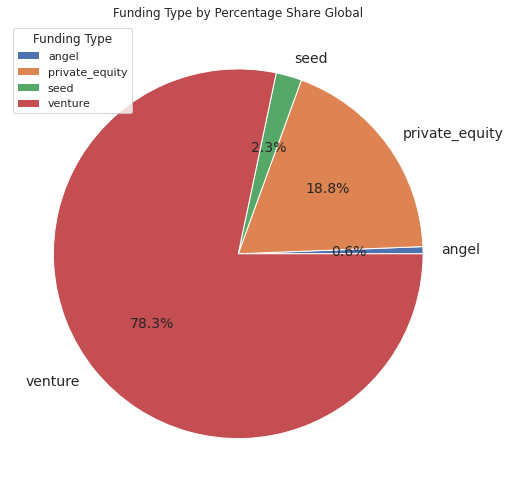

In [73]:
share_plot = fund_type_df.plot.pie(y=('raised_amount_usd','sum'),autopct='%.1f%%',legend=True,use_index=True,title='Funding Type by Percentage Share Global', textprops={'fontsize': 14}, figsize=(8.5,8.5))
share_plot.set_xlabel("")
share_plot.set_ylabel("")
share_plot.legend(title="Funding Type")


Text(-0.2, 15000000, 'Upper Limit (15 million USD)')

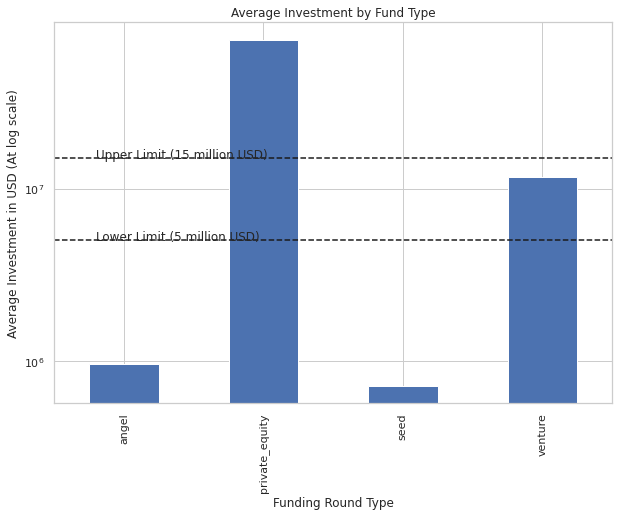

In [74]:
avg_plot = fund_type_df[[('raised_amount_usd','mean')]].plot.bar(legend=False,logy=True,title="Average Investment by Fund Type",figsize=(10,7))
avg_plot.set_xlabel("Funding Round Type")
avg_plot.set_ylabel("Average Investment in USD (At log scale)")
avg_plot.axhline( y=5000000, xmin=0, xmax=1,color='k', linestyle='--')
avg_plot.text(-0.20,5000000, "Lower Limit (5 million USD)")
avg_plot.axhline( y=15000000, xmin=0, xmax=1,color='k', linestyle='--')
avg_plot.text(-0.20,15000000, "Upper Limit (15 million USD)")


Assumption: Mean is the  most representative of the data distribution

---
## Q2. A plot showing the top 9 countries against the total amount of investments of funding type FT. This should make the top 3 countries (Country 1, Country 2, and Country 3) very clear.

In [75]:
top9.head()
#df for checkpoint 6 question 2
c6_q2 = pd.DataFrame(index=top9.index, columns=['sum_invested','english_speaking'])
c6_q2['sum_invested'] = top9[('raised_amount_usd','sum')]
c6_q2['english_speaking'] = ['Yes','No','Yes','Yes','Yes','No','Yes','No','No']
c6_q2

,sum_invested,english_speaking
country_code,,
USA,4.336758e+11,Yes
CHN,4.506542e+10,No
GBR,2.131203e+10,Yes
IND,1.565186e+10,Yes
CAN,9.943332e+09,Yes
DEU,7.599332e+09,No
FRA,7.524737e+09,Yes
ISR,7.477515e+09,No
JPN,3.541877e+09,No


Text(0, 0.5, 'Investment (At log scale)')

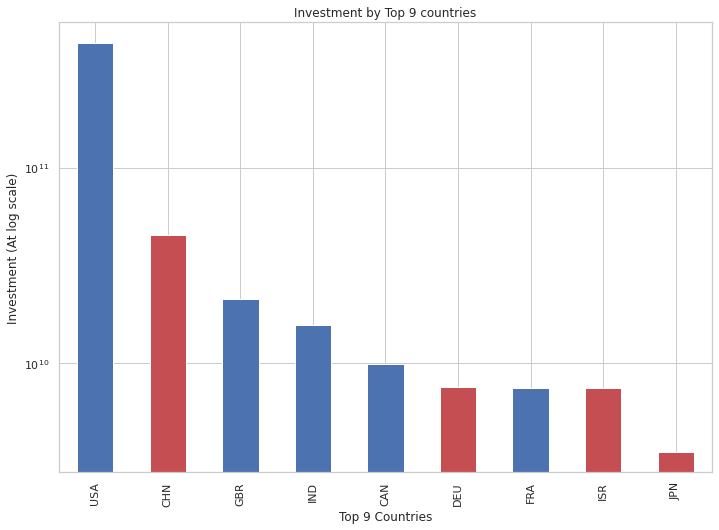

In [76]:
colors = {'Yes': 'b', 'No': 'r'}
top9_plot = c6_q2['sum_invested'].plot(kind='bar',logy=True,title="Investment by Top 9 countries", color=[colors[i] for i in c6_q2['english_speaking']])
top9_plot.set_xlabel("Top 9 Countries")
top9_plot.set_ylabel("Investment (At log scale)")

##### Plot 2. Investment by countries (red color depicts non-english speaking countries)

Assumptions: 
1. Top countires are one with highest sum invested in selected funding type (Venture)
2. Venture is the most suitable funding type considering the budget    

---
## Q3.A plot showing the number of investments in the top 3 sectors of the top 3 countries on one chart (for the chosen investment type FT).
FT= 'venture'

In [77]:
#adding country to df
for key,item in top_3_sector_by_company.items():
    top_3_sector_by_company[key]['country_code'] = key


In [78]:
#concatenating all top3 countries df having top 3 sectors
top_3_sector_by_country_all =  pd.concat([top_3_sector_by_company['USA'], top_3_sector_by_company['GBR'],top_3_sector_by_company['IND']],axis=0)
top_3_sector_by_country_all.head()

,main_sector,total_no_of_investment_by_sector,total_amount_invested_by_sector,country_code
2,Others,3403.0,2.858601e+10,USA
0,"Social, Finance, Analytics, Advertising",3290.0,2.668738e+10,USA
11,Cleantech / Semiconductors,2622.0,2.299343e+10,USA
12,Others,147.0,1.283624e+09,GBR
0,"Social, Finance, Analytics, Advertising",133.0,1.089404e+09,GBR


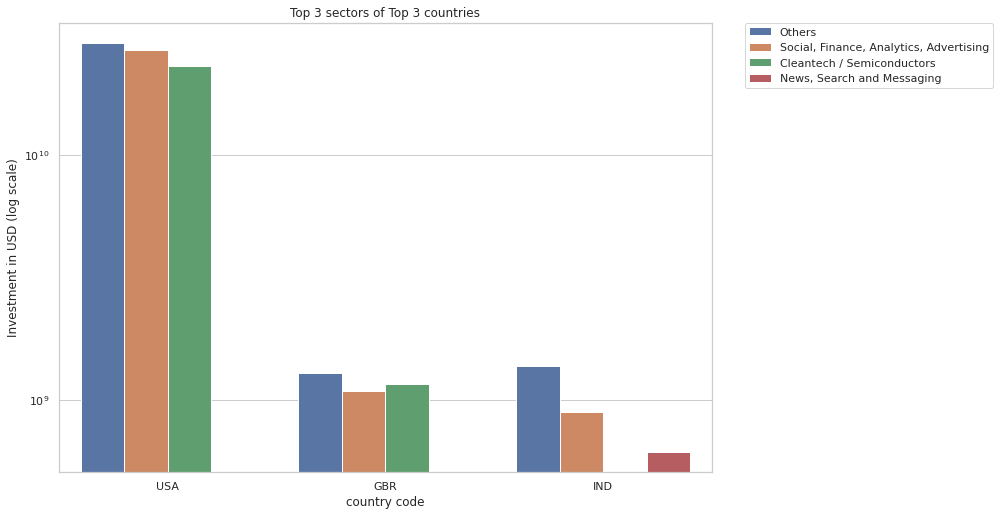

In [79]:
#Plot
top_sectors_plot = sns.barplot(x='country_code', y='total_amount_invested_by_sector', hue='main_sector', data=top_3_sector_by_country_all)
plt.ylabel('Investment in USD (log scale)')
plt.xlabel('country code')
plt.title('Top 3 sectors of Top 3 countries')
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
top_sectors_plot.set_yscale("log")

---
                                                         End of Assignment
---